# Content-based Recommendation System in Python
### Using Natural Language Processing (NLP) on wine reviews to recommend the next purchase

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from collections import defaultdict
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from rake_nltk import Rake

import progressbar
from IPython.display import HTML

%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
sns.set()
pd.options.display.max_colwidth = 100

In [2]:
# Loading the data
df = pd.read_csv('data/winemag-data-130k-v2.csv')
del df['Unnamed: 0']
# Show df to get an idea of the data
df.head(2)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressi...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled o...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos


## Data Analysis and definition of the project goals from a business perspective


For this project, I was interested in using data from my professional background in the beverage retail business. I am currently working as a data analyst in this domain, so the question of recommending wine is a of personal interest to me.  

From a business perspective, it is important to develop methods of creating a personal customer experience. When you are a high revenue customer or are in a shop with well-trained salespersons than chance is good to get excellent wine recommendations. In general, the shopping experience will benefit greatly from a personal approach to a given product. 
In the chosen dataset this kind of personal knowledge is ingrained in the written description of a wine. I want to translate that information into an algorithmic recommendation. The use case in mind would be an enriched sales process per email or phone.

The questions I pose in the analysis are

**1.) How many different Tasters are in the dataset, and how do they rate?**
 * The rating and description of a wine is provided by a specific taster. I want to know more about those persons and their rating behavior.  

**2.) What kind of information does the written description contain?**
 * The written description is a summary of the tasting experience and should provide enough information about the wine to provide an informed understanding of the wine's characteristics. 

**3.) How good is a recommendation engine based on description texts?** 
 * Does a recommendation based on this information in text form provide a useful experience for the customers

The focus of the project lies in this last, central question. I want to experiment with content-based recommendation engines as well as with natural language processing, so this dataset provides a good opportunity to experiment with both aspects.

### Genereal Data Analysis

#### Statistics

In [3]:
df.describe()

,points,price
count,129971.000000,120975.000000
mean,88.447138,35.363389
std,3.039730,41.022218
min,80.000000,4.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,3300.000000


The mean rating is 88.45 points with a standard deviation of 3.  
The mean price of a bottle wine is 35.36 Dollar, the standard deviation 41.02. The most expansive wine has a price of 3,300.- Dollar. With this spread of prices, the median of 25.-  Dollar is a better way to measure the middle.  

#### How are the ratings distributed across the varieties of the wines?

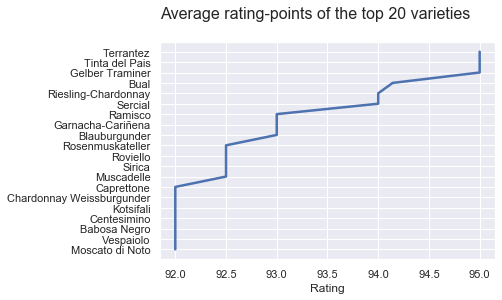

In [4]:
var = df.groupby('variety').points.mean().sort_values()[-20:]
y = var.index.to_list()
x = var.to_list()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, y, linewidth=2.5)

ax.set_title('Average rating-points of the top 20 varieties\n', size=16, loc='left')
ax.set_xlabel('Rating')

plt.savefig('Average_rating_top20')
plt.show()


The top 3 rated varieties are the Terrantez, the Tinta del Pais, and the Gelbe Traminer with an average rating of 95 points. It is interesting that in the region of the top 20 rated wines, we can see a drop in the scores of 3 points.

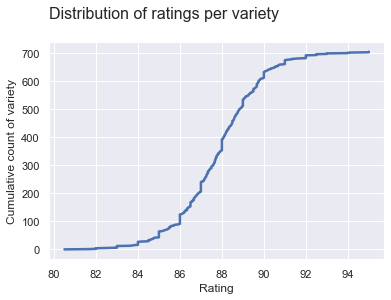

In [5]:
var = df.groupby('variety').points.mean().sort_values()
#y = var.index.to_list()
x = var.to_list()
y = range(0,len(var))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x,y, linewidth=2.5)

ax.set_title('Distribution of ratings per variety \n', size=16, loc='left')
ax.set_ylabel('Cumulative count of variety')
ax.set_xlabel('Rating')

plt.savefig('Variety_Rating_distr')
plt.show()

The average ratings per variety are cumulative distributed on a sigmoid curve.  

With this initial knowledge of the data we can tackle the main questions.

### 1.) How many different Tasters are in the dataset, and how do they rate?

* The rating and description of a wine is provided by a specific taster. 
* I want to know more about those persons and there rating behavior.

In [6]:
df.taster_name.nunique()

19

There are 19 different Taster in the dataset

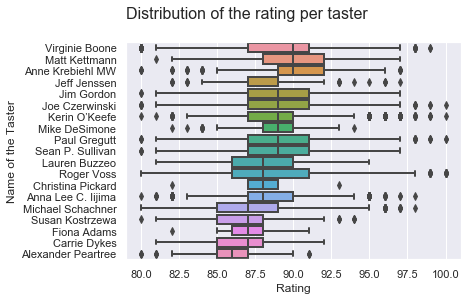

In [7]:
taster = df.groupby('taster_name').points.median().sort_values(ascending=False)
taster_order = taster.index.tolist()

fig = plt.figure()
ax = fig.add_subplot(111)
ax = sns.boxplot(y="taster_name", x="points", data=df, linewidth=2, order=taster_order)

ax.set_title('Distribution of the rating per taster \n', size=16, loc='left')
ax.set_xlabel('Rating')
ax.set_ylabel('Name of the Taster')

plt.savefig('Average_Rating_Taster')
plt.show()

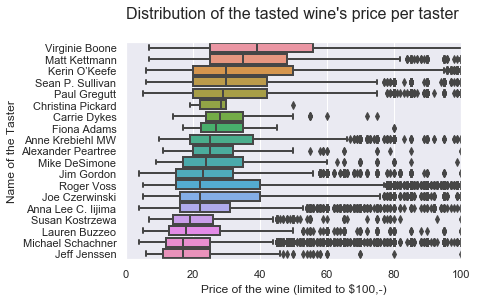

In [8]:
taster = df.groupby('taster_name').price.median().sort_values(ascending=False)
taster_order = taster.index.tolist()

fig = plt.figure()
ax = fig.add_subplot(111)
ax = sns.boxplot(y="taster_name", x="price", data=df, linewidth=2, order=taster_order)
plt.xlim(0, 100)

ax.set_title("Distribution of the tasted wine's price per taster \n", size=16, loc='left')
ax.set_xlabel('Price of the wine (limited to $100,-)')
ax.set_ylabel('Name of the Taster')

plt.savefig('Average_Price_Taster')
plt.show()

* There are 19 different Taster overall, 
* which rate on average between 85.86 and 90.56 points.
* The distribution shows that the taster have a different price range of wines to taste. 
* The top 2 taster in the price and rating section are the same


### 2.) What kind of information does the written description contain?

* To construct the recommendation engine it is important to understand the content of the text descriptions

In [9]:
# Taking a look at the describtions
for i in range(1,5):
    print(i)
    print(df['description'].loc[i])

1
This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's  already drinkable, although it will certainly be better from 2016.
2
Tart and snappy, the flavors of lime flesh and rind dominate. Some green pineapple pokes through, with crisp acidity underscoring the flavors. The wine was all stainless-steel fermented.
3
Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.
4
Much like the regular bottling from 2012, this comes across as rather rough and tannic, with rustic, earthy, herbal characteristics. Nonetheless, if you think of it as a pleasantly unfussy country wine, it's a good companion to a hearty winter stew.


In this small subset, we can find some characteristics of the descriptions:
* **associative terminology:** the taste of wine is described with associations like green pineapple, earthy and herbal notes, red berry fruits
* **descriptive terminology:** flavors with a direct understanding like dryness, taste of tannins, acidity, and sweetness
* other information about the wine: in some cases, information like the best year to drink the wine, the province or region, or the variety are also described in the text.  

#### How many characters does a describtion have?

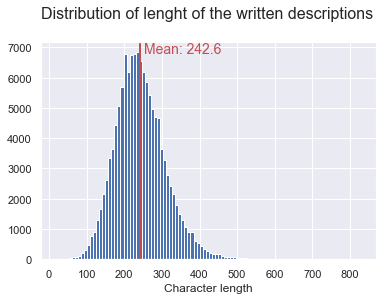

In [10]:
descr_len = df.description.apply(len)
descr_mean = np.round(np.mean(descr_len),1)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(descr_len, bins=100)
plt.axvline(descr_mean, linewidth=2, color='r')
plt.text(descr_mean + 10,6800,'Mean: {}'.format(descr_mean), color='r', size=14)

ax.set_title('Distribution of lenght of the written descriptions \n', size=16, loc='left')
ax.set_xlabel('Character length')

plt.savefig('Descr_Char_length')
plt.show()

The character length of the descriptions is slightly right-skewed with a mean of 242.6 characters per description.  
To see the distribution of the different terms, let's split the text up into keywords.

In [11]:
# setting stopwords for now and later use
stop_words = set(stopwords.words("english"))

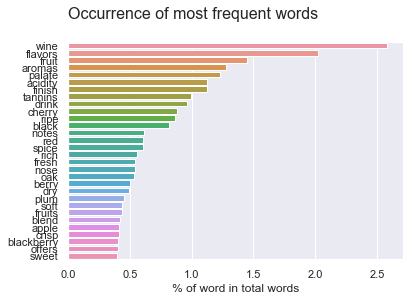

In [12]:
# Detokenizer combines tokenized elements
detokenizer = TreebankWordDetokenizer()

def wrangl_desc(desc):
    desc = word_tokenize(desc.lower())
    desc = [token for token in desc if token not in stop_words and token.isalpha()]
    return detokenizer.detokenize(desc)

df["wrangl_desc"] = df["description"].apply(wrangl_desc)
word_occurrence = df["wrangl_desc"].str.split(expand=True).stack().value_counts()
total_words = sum(word_occurrence)

# plot most common words 
top_words = word_occurrence[:30]/total_words
ax = sns.barplot(x = top_words.values * 100, y = top_words.index)
ax.set_title("Occurrence of most frequent words \n", size=16, loc='left')
ax.set_xlabel('% of word in total words')

plt.savefig('Most_common_words')
plt.show()


In [13]:
# adding not relevant words to the stop_words set
irrev = {'wine', 'flavors', 'palate', 'drink', 'aromas'}
stop_words.update(irrev)

* I added meaningless terms to the stopwords
* The distribution shows that the different aspects of a wine - the smell, the taste, the associations are well represented in the descriptions. 
* with this we can tackle the central question of the project:

### 3.) How good is a recommendation engine based on description texts?

To answer this question, there is some data wrangling to do

#### Checking for duplicates and NaN's
Overall there are 129971 different wines in the dataset with 13 columns.  

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 14 columns):
country                  129908 non-null object
description              129971 non-null object
designation              92506 non-null object
points                   129971 non-null int64
price                    120975 non-null float64
province                 129908 non-null object
region_1                 108724 non-null object
region_2                 50511 non-null object
taster_name              103727 non-null object
taster_twitter_handle    98758 non-null object
title                    129971 non-null object
variety                  129970 non-null object
winery                   129971 non-null object
wrangl_desc              129971 non-null object
dtypes: float64(1), int64(1), object(12)
memory usage: 13.9+ MB


In [15]:
# lets take a look at the NaN provinces
print(df[df['province'].isnull()].shape)
#df[df['province'].isnull()]

(63, 14)


There are 63 NaNs in the province column of the dataset.

In [16]:
# How many duplicated descriptions are in the data set?
df.duplicated('title').sum()

11131

In [17]:
# Find duplicate articles
#df[df.duplicated(['title'])].sort_values(by = 'title')

There are 11131 duplicated descriptions in the the dataset. Let's remove those and the duplicated descriptions and wines.

In [18]:
df.drop_duplicates('title', inplace=True)
df.drop_duplicates('description', inplace=True)

#### Extracting the vintage of a wine from its name to filter the dataset on a specific year

To handle the dataset and to provide just recommendations for available wines, the vintage has to be isolated and used as a filter.

In [19]:
years = df.title.str.extractall('(\d+)')
years.columns = ['year']
years.year = pd.to_numeric(years.year)
# filter vintage
years = years.query('year == 2016')

In [20]:
# check if there are duplicated index values
print(len(years))
print(years.index.get_level_values(level=0).nunique())

3303
3303


In [21]:
years.index = years.index.droplevel(level=1)
df = pd.concat([df, years], axis=1).dropna(subset=["year"])

#### Generating an ID for each wine

In [22]:
wine_id = list([x for x in range(0,len(df))])
df['wine_id'] = wine_id

#### Transforming the wine descriptions with tf-idf

In [23]:
docs = df.set_index('wine_id').description.astype('U')

In [24]:
r = Rake()
def tokenize(text):
    """
    Function to tokenize the descriptions
    For usage in the TfidfVectorizer Function
    """
    # normalize case and remove punctuation
    text = re.sub(r"[^a-zA-Z]", " ", text.lower())   
    r.extract_keywords_from_text(text)
    tokens = list(r.get_word_degrees().keys())
    tokens = [token for token in tokens if token not in stop_words]
    #stemmed = [PorterStemmer().stem(w) for w in tokens]
    lemmed = [WordNetLemmatizer().lemmatize(w) for w in tokens]
    tagged = nltk.pos_tag(lemmed)
    clean_tokens = [token[0] for token in tagged if token[1][0] in ['N', 'J']]
    return clean_tokens

In [25]:
# Fit the docs to the Vectorizer
tf = TfidfVectorizer(tokenizer=tokenize, analyzer='word')
   
X_docs = tf.fit_transform(docs)
labels = list(tf.get_feature_names())

print(X_docs.toarray().shape)

(3303, 3803)


#### Creating a matrix with the cosine similarity of the tf-idf values

In [26]:
# get a matrix with the tfidf values
corpus_matrix = X_docs.toarray()

# Take the dot product for the cosine similarity
dot_prod_corpus = corpus_matrix.dot(np.transpose(corpus_matrix))

# Create Dataframe with keywords:
key_words = pd.DataFrame(data=corpus_matrix, columns = labels).transpose()

### Define a function to find top n similar wines for a given wine id


To recommend a wine for a customer is a tricky business.  You should know how much a buyer is willing to spend on a purchase. What provinces and varieties a person prefers and how important the wine rating is for the customer.  Those points aside, the domain knowledge of sommeliers and wine salespeople is invaluable to classify wines and recommend based on experience.   

So, for this data science post, I want to investigate if the description of wines in this dataset, combined with provinces and varieties, holds enough information to base recommendations solely on these.

In [27]:
# Function to get a wine description:
def print_wine(wine_id):
    '''
    Function to pretty print a specific wine
    INPUT
    wine_id - a wine id
    '''
    try:
        wine = df[df['wine_id']==wine_id]
        title = wine.iloc[0,10]
        prov = wine.iloc[0,5]
        print("Wine: {}".format(title))
        print("Province: {}".format(prov))
        print("Variety: {}".format(wine.iloc[0,11]))
        print("Points: {}".format(wine.iloc[0,3]))
        print("Price: {}".format(wine.iloc[0,4]))
        print("Taster: {}".format(wine.iloc[0,8]))
        print("Description: {}".format(wine.iloc[0,1]))
        print("========================================================================")
    except:
        print("Please give a valid wine id (integer 0 to {})". format(len(df)))

In [28]:
def get_wine_names(wine_ids):
    '''
    Function to get the wine names in a list
    INPUT
    wine_id - a wine id
    OUTPUT
    wines - a list of wines associated with the wine_ids
    
    '''
    if type(wine_ids)==int:
        wine_ids = [wine_ids]
    wine_lst = [df[df.wine_id==wine]['title'].to_string(index=False,header=False) for wine in wine_ids]    
   
    return wine_lst

In [29]:
def find_similar_wines(wine_id, n=5):
    '''
    Function to get similar wines for a specific wine ID
    INPUT
    wine_id - a wine id
    n - number of similar wines to return
    OUTPUT
    df_sim - a dataframe of the most similar wines by id, name and similarity
    '''
    # find the most similar wine indices 
    key_words_sims = []
    
    similar_idxs = np.argsort(dot_prod_corpus[wine_id])[::-1][1:n+1]
    sims = np.sort(dot_prod_corpus[wine_id])[::-1][1:n+1]
    for idx in similar_idxs:
        wine_keys = key_words[key_words[idx] > 0][idx]
        wine_keys = list(wine_keys.index)[::1]
        key_words_sims.append(wine_keys)

    # pull the movie titles based on the indices
    similar_wines = get_wine_names(similar_idxs)
    
    # dataframe with similarities:
    d = {'wine_id': similar_idxs, 
         'wine': similar_wines,
        'similarity': sims, 
        'key_words': key_words_sims}
    df_sims = pd.DataFrame(d)
 
    return df_sims

In [30]:
df_sims = find_similar_wines(425)
print_wine(435)
df_sims.head()

Wine: Leyda 2016 Single Vineyard Garuma Sauvignon Blanc (Leyda Valley)
Province: Leyda Valley
Variety: Sauvignon Blanc
Points: 87
Price: 18.0
Taster: Michael Schachner
Description: A typically snappy opening with the pop of jalapeño gives way to a laser-sharp palate with bold acidity. Tart, mouthwatering citrus flavors come with green, herbal notes. This is cleansing and bone dry on the finish, but always a touch vegetal.


,wine_id,wine,similarity,key_words
0,1692,Château de Marsan 2016 Bordeaux Blanc,0.875996,"[acidity, broader, character, citrus, crisp, intense, late, riper, tight, wait]"
1,1204,Neumeister 2016 Steirische Klassik Sauvignon Blanc,0.278621,"[citrus, core, crisp, fruit, lean, light, midpalate, refreshing, riper, savor, slight, spritz, w..."
2,2025,Les Rocailles 2016 Apremont Vieilles Vignes Jacquère (Savoie),0.273432,"[acidity, bright, character, citrus, concentrate, crisp, fresh, great, intense, ready, salty, ti..."
3,2869,Château de l'Aubrade 2016 Bordeaux Blanc,0.271416,"[acidity, apricot, balance, citrus, crisp, family, favor, intense, late, lobre, riper, rope, taut]"
4,1196,Herdade do Esporão 2016 V Verdelho (Alentejano),0.263804,"[acidity, character, drunk, grape, herbal, intense, late, spice, tangy, young]"


In [31]:
for i in df_sims.wine_id:
    print('ID of the wine: {} \n'.format(i))
    print_wine(i)

ID of the wine: 1692 

Wine: Château de Marsan 2016  Bordeaux Blanc
Province: Bordeaux
Variety: Bordeaux-style White Blend
Points: 88
Price: 12.0
Taster: Roger Voss
Description: This wine is tight, crisp with citrus flavors and intense acidity. It is developing into a refreshing, broader wine that will have a riper character. Wait until late 2017.
ID of the wine: 1204 

Wine: Neumeister 2016 Steirische Klassik Sauvignon Blanc
Province: nan
Variety: Sauvignon Blanc
Points: 89
Price: 25.0
Taster: Anne Krebiehl MW
Description: Just a whiff of citrus shows on the restrained nose. The palate is very crisp, even lean, disclosing slight spritz. Some riper fruit waits at the core but you have to savor the midpalate to find it. The wine is light and very refreshing.
ID of the wine: 2025 

Wine: Les Rocailles 2016 Apremont Vieilles Vignes Jacquère (Savoie)
Province: France Other
Variety: Jacquère
Points: 89
Price: 18.0
Taster: Roger Voss
Description: Intense and crisp, this wine concentrates gre

### Create a function for content based recommendations



In [32]:
# Lets asume there are 100 consumers who bought each 5 wines
customer_dict = {}
for cust in range(1,101):
    customer_dict[cust]= list(np.random.randint(len(df), size=5))
customer_dict[2]

[544, 3176, 1103, 520, 2070]

In [33]:
def make_content_recs(n=5):
    '''
    INPUT
    n - Number of recommendations by user (default = 10)
    OUTPUT
    recs - a dictionary with keys of the user and values of the recommendations
    '''
    # Create dictionary to return with customers and recommendations
    recs = defaultdict(list)
    
    # How many customers for progress bar
    n_users = len(customer_dict)  
    # Create the progressbar
    cnter = 0
    bar = progressbar.ProgressBar(maxval=n_users+1, 
                                  widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    
    # For each customer
    for cust in customer_dict:
        # Update the progress bar
        cnter+=1 
        bar.update(cnter)
        
        # Wines allready consumed:
        cust_wines = customer_dict[cust]
        
        # find the simmilar wines for each wine_id and concat the data for all articles of the user:
        df_recs = pd.DataFrame()
        for wine_id in customer_dict[cust]:
            df_sim = find_similar_wines(wine_id)
            df_recs = pd.concat([df_recs,df_sim])
            
        #Sorting all wines according the similarity accross all suggestions
        df_recs = df_recs.sort_values('similarity', ascending=False).drop_duplicates('wine_id')
        
        # getting just the ids and filter allready bought wines:
        temp_recs = [wine for wine in df_recs.wine_id if wine not in cust_wines]
        
        # creating the dictionary with just the top n recommendations
        recs[cust]=temp_recs[:n]
        
    bar.finish()
    return recs

In [34]:
recommendations = make_content_recs()

[========================================================================] 100%


In [35]:
# Bought wines from customer 1:
for i in customer_dict[1]:
    print(i)
    print_wine(i)

96
Wine: Pacific Rim 2016 Wallula Vineyard Riesling (Horse Heaven Hills)
Province: Washington
Variety: Riesling
Points: 88
Price: 15.0
Taster: Sean P. Sullivan
Description: Subtle pear, orange rind and peach aromas lead this Riesling, along with a floral top note. It drinks off dry, with stone fruit and ale flavors that need more time in bottle to settle. It comes up a bit short on the finish.
1612
Wine: DFJ Vinhos 2016 Casa do Lago Rosé (Lisboa)
Province: Lisboa
Variety: Rosé
Points: 86
Price: 10.0
Taster: Roger Voss
Description: Perfumed and bright, this is an attractive blend that includes Pinot Noir and Syrah. With its ripe creamy texture and exuberant red fruits, the wine is ready to drink.
2528
Wine: Hess 2016 Shirtail Ranches Rosé (California)
Province: California
Variety: Rosé
Points: 87
Price: 13.0
Taster: Jim Gordon
Description: This copper-colored wine was made from mostly Rhône-style grapes and has earthy meaty aromas and flavors, a light to medium body and a texture that's

In [36]:
# Recommendations for customer 1
for i in recommendations[1]:
    print(i)
    print_wine(i)

188
Wine: Muddy Boot 2016 Rosé of Pinot Noir (California)
Province: California
Variety: Pinot Noir
Points: 86
Price: 13.0
Taster: Jim Gordon
Description: The deep-copper color and complex fruit aromas of this wine seem well matched with a rather broad texture and medium-full body. The raspberry flavors have a meaty savory accent.
2784
Wine: Henri Bourgeois 2016 Les Jeunes Vignes Rosé (Sancerre)
Province: Loire Valley
Variety: Rosé
Points: 87
Price: 20.0
Taster: Roger Voss
Description: The wine is simply crisp red-berry fruit. It has red-currant and wild-strawberry flavors along with intense bright acidity. It's an attractive Pinot Noir, ready to drink now.
2599
Wine: Brassfield 2016 Rosé (High Valley)
Province: California
Variety: Rosé
Points: 86
Price: 22.0
Taster: Jim Gordon
Description: This light-orange-colored wine has quite a bit of red wine character, from the raspberry aromas to rather meaty grapey flavors, smooth texture and medium to full body.
777
Wine: DFJ Vinhos 2016 Porta

## Conclusion

I think that the general quality of the recommendations is good. I believe that this way of comparing two different wines is an excellent addition to conventional ways of recommending wines like the province, variety, or price.  
To evaluate the recommendations further explicit domain knowledge should be used.  

**Further possibilities for developement:**
* Prefilter the recommendations with price, rating, province or other variables
* Combination of collaborative filtering with the content-based  recommendations
* Incorporating of the algorithm in a sales workflow